<a href="https://colab.research.google.com/github/ReyFrank92/joyofcoding/blob/main/AR_NN_Mezcla_Mexicana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install TensorFlow
!pip install -q tensorflow-gpu==2.9.1
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.6 MB 59.6 MB/s 
     |████████████████████████████████| 5.8 MB 30.4 MB/s 
     |████████████████████████████████| 438 kB 48.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.9.0 which is incompatible.
2.9.1


In [3]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense,  GRU, LSTM, GlobalMaxPool1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [4]:
from google.colab import files
data_to_load = files.upload()

Saving Mezcla Mexicana Resumen.csv to Mezcla Mexicana Resumen.csv


In [5]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
np.random.seed(0)
tf.random.set_seed(0)

In [7]:
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hideen units 
# K = number of output units

In [8]:
from sklearn.metrics import mean_absolute_percentage_error

In [9]:
df = pd.read_csv('Mezcla Mexicana Resumen.csv', index_col='Fecha', parse_dates=True)

In [10]:
df['LogMM'] = np.log(df['MM'])

In [11]:
Ntest = 70
train = df.iloc[:-Ntest] #todos -12
test = df.iloc[-Ntest:] #solo las últimas 12 observaciones

In [12]:
from typing import ValuesView
ValuesView(df)

ValuesView(                MM     LogMM
Fecha                       
1996-01-31   15.12  2.716018
1996-02-29   16.82  2.822569
1996-03-29   18.35  2.909630
1996-04-30   17.61  2.868467
1996-05-31   16.48  2.802148
...            ...       ...
2022-02-28   91.80  4.519612
2022-03-31   98.00  4.584967
2022-04-29  102.02  4.625169
2022-05-31  113.83  4.734706
2022-06-30  104.79  4.651958

[318 rows x 2 columns])

In [13]:
ValuesView(train)

ValuesView(               MM     LogMM
Fecha                      
1996-01-31  15.12  2.716018
1996-02-29  16.82  2.822569
1996-03-29  18.35  2.909630
1996-04-30  17.61  2.868467
1996-05-31  16.48  2.802148
...           ...       ...
2016-04-29  37.58  3.626472
2016-05-31  40.26  3.695358
2016-06-30  41.00  3.713572
2016-07-29  35.92  3.581294
2016-08-31  38.96  3.662535

[248 rows x 2 columns])

In [14]:
ValuesView(test)

ValuesView(                MM     LogMM
Fecha                       
2016-09-30   39.83  3.684620
2016-10-31   38.81  3.658678
2016-11-30   40.94  3.712108
2016-12-30   46.30  3.835142
2017-01-31   45.18  3.810655
...            ...       ...
2022-02-28   91.80  4.519612
2022-03-31   98.00  4.584967
2022-04-29  102.02  4.625169
2022-05-31  113.83  4.734706
2022-06-30  104.79  4.651958

[70 rows x 2 columns])

In [15]:
# boolean series to index df rows []
train_idx = df.index <= train.index[-1] #pone true a lo que sea train del data set y lo demás false
test_idx = df.index > train.index[-1] # pone true a lo que sea del test solamente y lo demás false

In [80]:
ValuesView(test_idx)

ValuesView(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       Fa

In [16]:
df['DiffLogMM'] = df['LogMM'].diff() #crea una nueva columna con la diferencia del logaritmo de los pasajeros

In [17]:
#Make supervised dataset
series = df['DiffLogMM'].dropna().to_numpy() #son 143/144 datos

T = 10
X = []
Y = []
for t in range(len(series) - T): #corre en el rango de 144-10 = 134
  x = series[t:t+T] #e.g. si t =1 entonces corre de 1 a 11
  X.append(x) #agrega lo anterior
  y = series[t+T] # e.g. si t = 1 entonces y es 11
  Y.append(y) #aagrega lo anterior

X = np.array(X).reshape(-1,T,1) #el tensor es una caja
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape",Y.shape)

X.shape (307, 10, 1) Y.shape (307,)


In [18]:
ValuesView(series)

ValuesView(array([ 1.06550284e-01,  8.70609200e-02, -4.11626520e-02, -6.63193980e-02,
        5.66188940e-02, -1.61853244e-02,  1.03435587e-01,  1.09398594e-01,
       -3.06097547e-02,  2.06688444e-02,  2.81444468e-02, -8.34017193e-02,
       -2.03355711e-01,  6.75470791e-03, -6.13875470e-03,  2.97261803e-02,
       -6.48175001e-02,  4.06178921e-02, -7.96345444e-02,  1.44249609e-01,
       -9.22728577e-03, -1.12726318e-01, -1.98798979e-01, -2.32103256e-02,
       -1.68011481e-01, -2.81708770e-02,  5.46374502e-02,  6.58785744e-02,
       -1.01969861e-01,  3.86100866e-03, -9.91711885e-02,  2.45029947e-01,
       -1.53595741e-01, -2.23143551e-01, -1.21432923e-03,  8.60996614e-02,
       -3.05626504e-02,  3.91575996e-01,  1.30905571e-01, -1.22394881e-01,
        1.54590821e-01,  1.13446547e-01,  1.14569602e-01,  1.16906842e-01,
       -1.19537730e-01,  1.33465532e-01,  1.64612771e-02,  6.92044893e-02,
        1.01332099e-01, -1.63306553e-01, -3.15599026e-02,  1.49893090e-01,
        8.6544

In [19]:
Xtrain, Ytrain = X[: -Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [20]:
print(Xtrain.shape)

(237, 10, 1)


In [21]:
print(Ytrain.shape)

(237,)


In [22]:
print(Xtest.shape) 

(70, 10, 1)


In [23]:
print(Ytest.shape)

(70,)


In [24]:
295+12

307

In [25]:
#RNN 
i = Input(shape=(T,1))
x = LSTM(12)(i)
x = Dense(1)(x)
model = Model(i,x)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 12)                672       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [28]:
print(Xtrain.shape, Ytrain.shape)

(237, 10, 1) (237,)


In [29]:
print(Xtest.shape, Ytest.shape)

(70, 10, 1) (70,)


In [30]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
)

Epoch 1/100
8/8 [==============================] - 4s 150ms/step - loss: 0.0136 - val_loss: 0.0454
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0134 - val_loss: 0.0455
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0133 - val_loss: 0.0455
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0132 - val_loss: 0.0455
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0132 - val_loss: 0.0454
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0455
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0131 - val_loss: 0.0455
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0130 - val_loss: 0.0454
Epoch 9/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0130 - val_loss: 0.0454
Epoch 10/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0130 - val_loss: 0.0455
Epoch 11/100
8/8 [

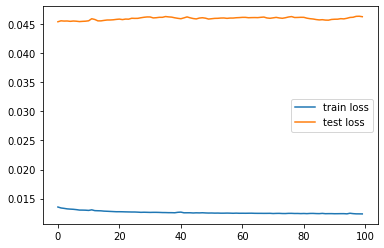

In [31]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [32]:
train_idx[:T+1] = False # First T+1 values are not predictable

In [33]:
print(train_idx[:T+1]) #Me imprime lo que tenemos False en el entrenamiento 

[False False False False False False False False False False False]


In [34]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

3/3 [==============================] - 0s 11ms/step


In [35]:
print(Ptrain.shape)

(237,)


In [36]:
print(Ptest.shape)

(70,)


In [37]:
print(series.shape)

(317,)


In [83]:
237+70+10

317

In [38]:
143-121-12 #es 10 porque el T = 10. 

10

In [39]:
#Needed to compute un-differenced predictions
df['ShiftLogMM'] = df['LogMM'].shift(1) #cambia 1 periodo hacia adelante los datos
prev = df['ShiftLogMM']
ValuesView(prev.tail())

ValuesView(Fecha
2022-02-28    4.420165
2022-03-31    4.519612
2022-04-29    4.584967
2022-05-31    4.625169
2022-06-30    4.734706
Name: ShiftLogMM, dtype: float64)

In [40]:
print(prev.shape)

(318,)


In [41]:
# Last-known train value
last_train = train.iloc[-1]['LogMM']

In [42]:
ValuesView(last_train)

ValuesView(3.6625354787743345)

In [81]:
print(Ptrain.shape, prev[train_idx].shape)

(237,) (237,)


In [43]:
# 1-step forecast[]
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain #Te regresa las 121 observaciones con true //con el loc me regresa del df algo en específico //prev[train_idx] =121 lenght + 121 lenght ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest #Te regresa las 12 observaciones con true // prev[test_idx] 12 lenght + ptest 12 lenght

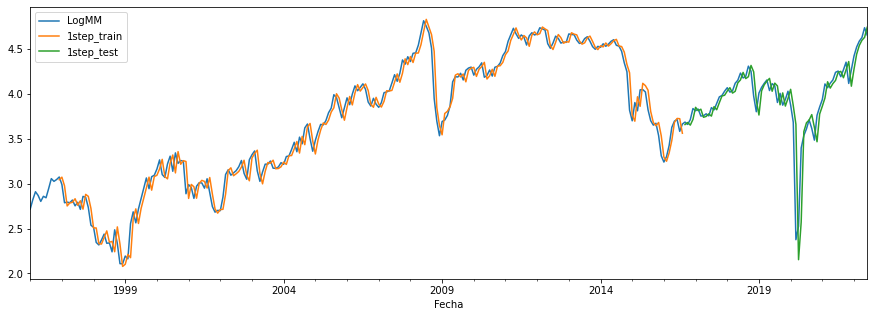

In [44]:
# Plot 1-step forecast []
df[['LogMM','1step_train','1step_test']].plot(figsize=(15,5));

In [45]:
#multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0] #acá hay 10 observaciones

while len(multistep_predictions) < Ntest:#Ntest es 12, entonces el while es hasta 11. Prediceme las sig 12 observaciones. Recuerda que 11 es la 12 porque se incluye el 0
  p = model.predict(last_x.reshape(1,-1, 1))[0]#damelo en 1 fila por x columnas que no se cuantas son. (el que debe de ir es 1,-1)
  #update the predictions list
  multistep_predictions.append(p)#añademe el resultado a p

  #make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

1/1 [==============================] - 0s 24ms/step


In [46]:
print(p)

[0.00090451]


In [47]:
#save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

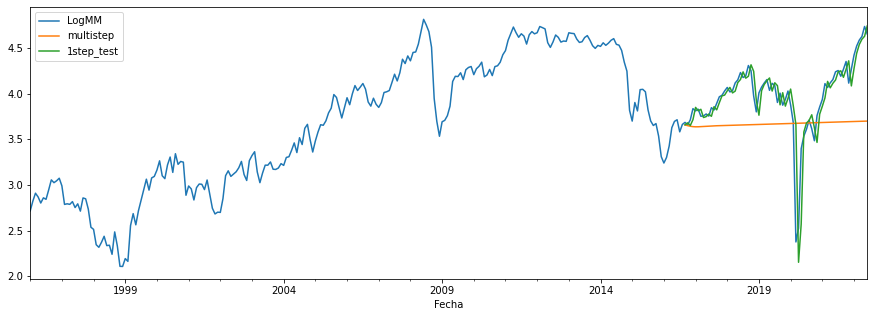

In [48]:
#plot 1-step and multi-step forecast
df[['LogMM','multistep','1step_test']].plot(figsize=(15,5));

In [49]:
# make multi-output supevised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series)- Tx -Ty +1):
  x = series[t:t+Tx] #si t es 1 enotnces corre de 1 a 11
  X.append(x)
  y =series[t+Tx:t+Tx+Ty] #si t es 1, entonces corre de 11 a (1+10+12 = 23)
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (238, 10, 1) Y.shape (238, 70)


In [50]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [51]:
#RNN
i = Input(shape=(Tx,1))
x = LSTM(36, return_sequences=True)(i)
x = GlobalMaxPool1D()(x) #NameError: name 'GlobalMaxPooling1D' is not defined
x = Dense(Ty)(x) #en este caso es 12 =Ty
model = Model(i,x)

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 36)            5472      
                                                                 
 global_max_pooling1d (Globa  (None, 36)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 70)                2590      
                                                                 
Total params: 8,062
Trainable params: 8,062
Non-trainable params: 0
_________________________________________________________________


In [53]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss',save_best_only=True
)

In [54]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [55]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m, Ytest_m),
    callbacks=[check_point],
)

Epoch 1/300
8/8 [==============================] - 3s 78ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 2/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/300
8/8 [==============================] - 0s 10ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 4/300
8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 5/300
8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 6/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 7/300
8/8 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 8/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 9/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 10/300
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - val_loss: 0.0463
Epoch 11/300
8/8 [======

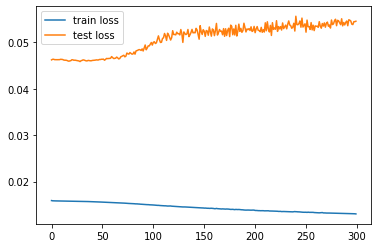

In [56]:
#Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [57]:
#load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [58]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 20ms/step


In [59]:
Ptrain.shape, Ptest.shape

((237, 70), (1, 70))

In [60]:
Ptrain = Ptrain[:,0]
Ptest = Ptest [0]

In [61]:
print(Ptest)

[-0.01271022 -0.00628346 -0.09747483 -0.08256947 -0.0048377   0.06649442
  0.09682003 -0.04252439 -0.08118169  0.00219438  0.03245952  0.01929126
 -0.00135113 -0.05041664  0.00486879  0.02406464 -0.04957066 -0.04395539
 -0.01863568  0.04568156  0.09216165  0.00754236  0.03716557 -0.00763535
 -0.00065803  0.01779968 -0.01161787 -0.06697825 -0.08130637 -0.00797663
  0.11956728  0.14671768  0.06908678  0.03772711  0.0397072   0.07638514
 -0.00272229 -0.03081908 -0.12879002 -0.01680546  0.08134528  0.03737079
  0.00113512 -0.20665628 -0.02296162  0.17558299  0.12847525  0.00559886
 -0.00108593 -0.11363997 -0.02201131  0.03696427 -0.03689237 -0.15146083
 -0.11994757  0.06407157  0.14086205  0.02167683 -0.07030401 -0.00428373
 -0.00329398  0.12653957  0.13788335 -0.07349423 -0.04645566  0.06979116
 -0.00057908  0.05758931  0.04748395 -0.01946459]


In [62]:
# save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

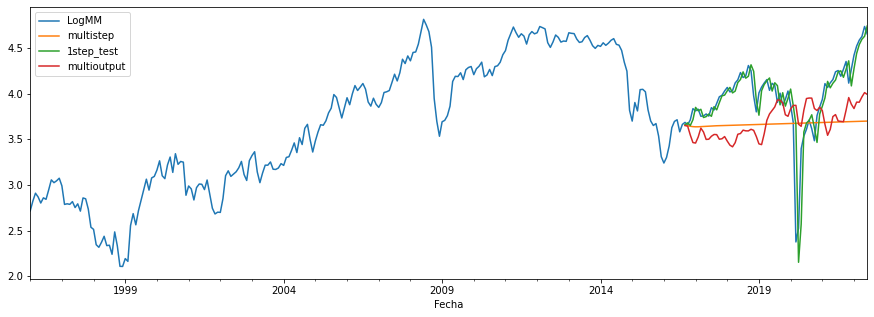

In [63]:
#plot all forecasts
cols = ['LogMM', 'multistep', '1step_test','multioutput']
df[cols].plot(figsize=(15,5));

In [64]:
#RNN multiple LSTM Layers
i = Input(shape=(Tx,1)) #recuerda Tx = T 
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPool1D()(x) #convertir la secuencia en 1 solo vector y aplicar solo una capa de densidad al final
x = Dense(Ty)(x) #Ty = Ntest el cual es 12 en el ejemplo
model = Model(i,x)

In [65]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            1152      
                                                                 
 lstm_3 (LSTM)               (None, 10, 16)            2112      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 70)                1190      
                                                                 
Total params: 4,454
Trainable params: 4,454
Non-trainable params: 0
_________________________________________________________

In [66]:
check_point = ModelCheckpoint(
    'best_model.h5',monitor='val_loss',save_best_only=True)


In [67]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [68]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=300,
    validation_data=(Xtest_m,Ytest_m),
)

Epoch 1/300
8/8 [==============================] - 5s 139ms/step - loss: 0.0159 - val_loss: 0.0462
Epoch 2/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0159 - val_loss: 0.0463
Epoch 3/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 4/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 5/300
8/8 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0464
Epoch 6/300
8/8 [==============================] - 0s 15ms/step - loss: 0.0158 - val_loss: 0.0465
Epoch 7/300
8/8 [==============================] - 0s 20ms/step - loss: 0.0158 - val_loss: 0.0465
Epoch 8/300
8/8 [==============================] - 0s 14ms/step - loss: 0.0158 - val_loss: 0.0465
Epoch 9/300
8/8 [==============================] - 0s 16ms/step - loss: 0.0158 - val_loss: 0.0465
Epoch 10/300
8/8 [==============================] - 0s 17ms/step - loss: 0.0158 - val_loss: 0.0465
Epoch 11/300
8/8 [

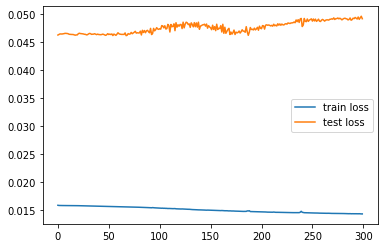

In [69]:
#Plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [70]:
#load best model 
best_model = tf.keras.models.load_model('best_model.h5')


In [71]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/1 [==============================] - 0s 23ms/step


In [72]:
print(Ptest)

[ 0.01353014  0.00372925 -0.03748224 -0.02830293  0.01109946  0.07643322
  0.12094112  0.05064327  0.03412501  0.02370544  0.01206806  0.00512242
 -0.00948254 -0.01730065  0.02785708  0.01126505 -0.01189294 -0.01353741
 -0.043453    0.02681865  0.05842818  0.02902901  0.02302895  0.02748686
  0.02703259  0.0281279  -0.00677405 -0.03040585 -0.02664273 -0.0087637
  0.0410961   0.04502723  0.01743777  0.01892879  0.02293528  0.02572893
 -0.01855818 -0.06600335 -0.09595587 -0.03732388  0.06630471  0.09011127
  0.0395906  -0.04431362  0.06537671  0.10196479  0.00587907 -0.02142904
 -0.04186666 -0.02395457  0.02243082  0.05708782  0.01661287 -0.14314519
 -0.12942618  0.04021553  0.11890844  0.11869346 -0.01793209 -0.05629105
 -0.03936634  0.02894244  0.05056842  0.01520536  0.03252469  0.0590689
  0.03165824  0.00829391 -0.05214977 -0.00647914]


In [73]:
print(last_train)

3.6625354787743345


In [74]:
print( np.cumsum(Ptest))

[ 0.01353014  0.01725939 -0.02022284 -0.04852577 -0.03742632  0.0390069
  0.15994802  0.21059129  0.24471629  0.2684217   0.28048977  0.2856122
  0.27612966  0.25882903  0.28668612  0.29795116  0.28605822  0.2725208
  0.2290678   0.25588647  0.31431463  0.34334365  0.3663726   0.39385945
  0.42089203  0.44901994  0.4422459   0.41184005  0.3851973   0.3764336
  0.4175297   0.46255693  0.47999468  0.49892348  0.52185875  0.5475877
  0.5290295   0.46302614  0.36707026  0.32974637  0.39605108  0.48616236
  0.52575296  0.48143935  0.54681605  0.6487808   0.65465987  0.6332308
  0.59136415  0.5674096   0.5898404   0.64692825  0.66354114  0.52039593
  0.39096975  0.43118528  0.5500937   0.6687872   0.65085506  0.594564
  0.55519766  0.5841401   0.6347085   0.6499139   0.6824386   0.74150753
  0.77316576  0.7814597   0.7293099   0.7228308 ]


In [75]:
#save multi-output forecast to dataframe []
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

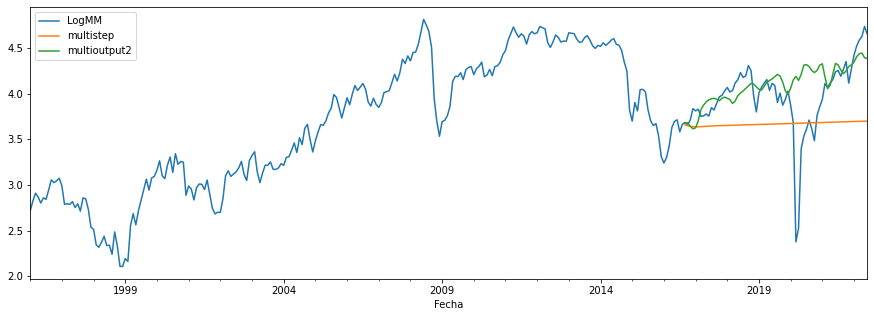

In [76]:
# plot all forecasts
cols = ['LogMM', 'multistep','multioutput2']
df[cols].plot(figsize=(15,5));

In [77]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogMM']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output(2 LSTMs MAPE:", mape3)

multi-step MAPE: 0.09995078345403499
multi-output MAPE: 0.10625785566593787
multi-output(2 LSTMs MAPE: 0.0681162208345927
